Simulation of moving bar with two cell types and delayed feedback
July 28, 2020 created by CKC
based on NF_MB_02 but with a smooth moving bar by using a stimulation with continuous position

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
def K(x,s):
    return (np.exp(-(x/s)**2))/(s*np.sqrt(np.pi))

In [3]:
# Guassian function with mean x0 and standard deviation sigma
def G(x,x0,sigma):
    y = np.exp(-((x-x0)/sigma)**2)
    return(y)

In [4]:
sigma_h = 1.1 # all 'dimention-L' parameters are narmalize by sigma_h
sigma_c = 0.99*sigma_h
sigma_g = 5.*sigma_c

dx = 0.01*sigma_h
xlen = 5000 #spatial 'step' of simulation
xaxis = np.arange(0, xlen)*dx

dis_h = sigma_h
dis_c = sigma_c
h_loc = np.zeros(xlen)
locx = np.arange(dis_h, xlen*dx-dx, dis_h)/dx
h_loc[np.round(locx).astype(int)] = 1
c_loc = np.zeros(xlen)
locx = np.arange(dis_c, xlen*dx-dx, dis_c)/dx
c_loc[np.round(locx).astype(int)] = 1

sum(h_loc)

49.0

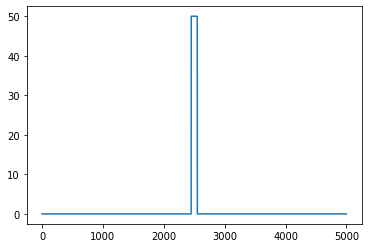

In [5]:
s = np.zeros(xlen)
i0 = xlen/2
hw = (sigma_h/2)
s[round(i0-hw/dx):round(i0+hw/dx)] = 50
plt.plot(s)

In [6]:
klen = sigma_h*3
xx = np.arange(-klen,klen,dx)

KC = K(xx,sigma_c)
KH = K(xx,sigma_h)
KG = K(xx,sigma_g)

In [7]:
alpha = 100
beta = 2
k = 800
g = sigma_h/sigma_c

k*g/alpha/beta

4.040404040404041

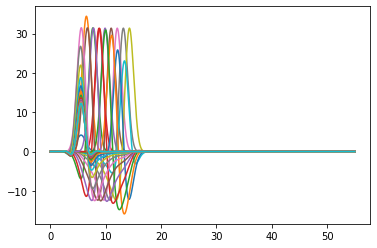

In [29]:
dt = 0.001



pos_0 = 503.*dx
nstep = 1500
vdt =  2*dx # moving bar velocity  #pos_0+vdt*400 <= xlen-pos0
#v = 0

y = np.zeros(xlen) # cone cell output
z = np.zeros(xlen) # horizontal cell output
rz = np.zeros(xlen) 
ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

speak = np.zeros(nstep)
rpeak = np.zeros(nstep)

stm = []
rsp = []
zts = []
tmp = []

for i in range(nstep):
    if i < 400:
        pos = pos_0 + vdt*i
    if i > 400 and i <800:
        pos = pos - vdt
        
    speak[i] = pos/dx
    
    s = np.zeros(xlen)
    s[round((pos-hw)/dx):round((pos+hw)/dx)] = 10
    rs =  np.convolve(s,KC,'same')*dx

    for j in range(xlen):
#         if c_loc[j]:
#             dyj =(-alpha*y[j]+k*(rs[j]-rz[j]))*dt
#             y[j] = y[j]+dyj
#         if h_loc[j]:
#             dzj =(-beta*z[j]+g*y[j])*dt
#             z[j] = z[j]+dzj
            
        dyj =(-alpha*y[j]+k*(rs[j]-rz[j]))*dt
        y[j] = y[j]+dyj
        dzj =(-beta*z[j]+g*y[j])*dt
        z[j] = z[j]+dzj
        
    rz = np.convolve(z,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    ry = np.convolve(y,KH,'same')*dx # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)

    output = np.convolve(y,KC,'same')/sum(h_loc)
    output = y
    
    rpeak[i]= np.argmax(output)
    
    stm.append(rs.copy())
    rsp.append(output.copy())
    zts.append(z.copy())
    
    if i%50 == 0:
        #plt.plot(y[maxpos-50:maxpos+50])
        plt.plot(xaxis, output)
        tmp.append(output)
        #plt.plot(rs/7)

(303.0, 703.0)

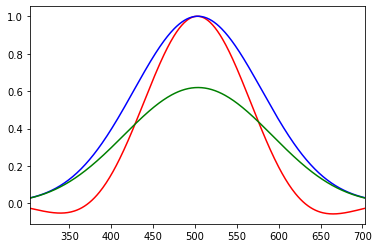

In [30]:
plt.plot(y/np.max(y),'r')
plt.plot(rs/np.max(rs),'b')
plt.plot(ry/np.max(output),'g')

#plt.plot(z)
plt.xlim([rpeak[-1]-200, rpeak[-1]+200])

In [31]:
# activation function
def A(x,theta):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

(403.0, 603.0)

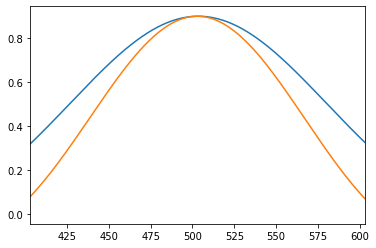

In [32]:
# shown with activatin function
rrs = rs/np.max(rs)
yy = output/np.max(output)
plt.plot(A(rrs,0.1))
plt.plot(A(yy,0.1))
plt.xlim([rpeak[-1]-100,rpeak[-1]+100])

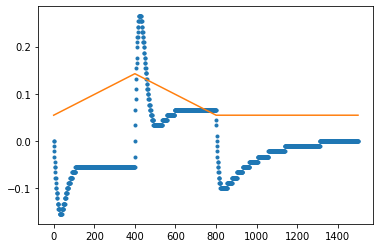

In [33]:
# difference between stimualtion and response peak
plt.plot((rpeak-speak)*dx,'.')
plt.plot((speak-pos_0)*dx*0.01)
#plt.ylim([0,15])
#plt.xlim([350,450])

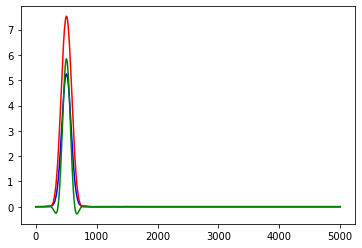

In [34]:
# spatial distribution of cells at final state
plt.plot(rs,'b') # stimualtion
plt.plot(ry,'r')  # cone cell
plt.plot(z,'g')  # horizontal cell


10


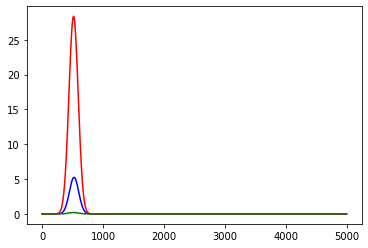

200


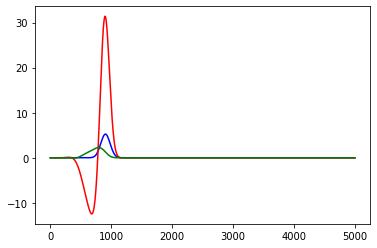

400


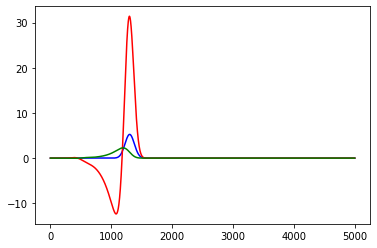

450


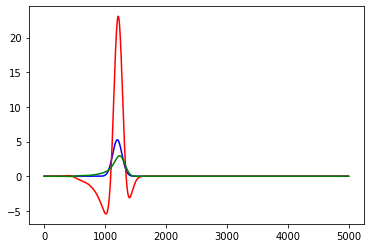

500


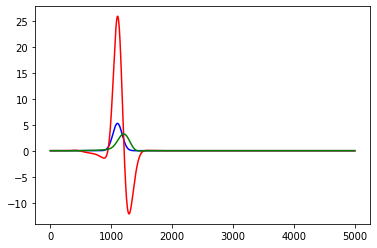

600


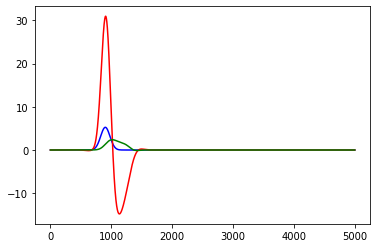

700


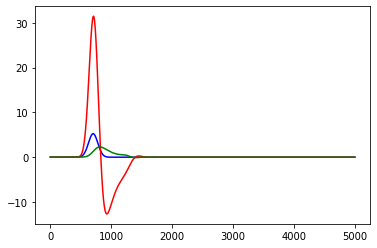

1199


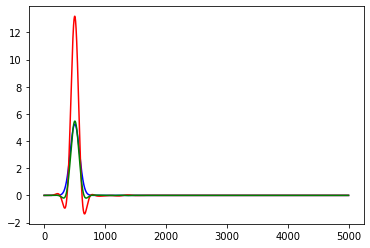

1499


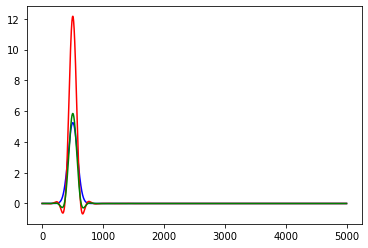

In [35]:
# snapshot at different time
for index in [10, 200, 400, 450, 500, 600, 700, 1199, 1499]:
    plt.figure()
    print(index)
    plt.plot(stm[index],'b')
    plt.plot(rsp[index],'r')
    plt.plot(zts[index],'g')
    plt.show()
